# PHYS 210 Mini-Project 04
### Maxwell Boltzmann Distribution
Due Wed, Nov 30, 2022 - 9am

In [60]:
# Main code and animation here
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from itertools import combinations
from IPython.display import HTML
import matplotlib
from scipy.optimize import curve_fit

# Do your testing using smaller numbers than these
# (Running this code as is will take a very long time)
npoint = 400
nframe = 500
xmin, xmax, ymin, ymax = 0, 1, 0, 1
Dt = 0.00002  # time step
particle_radius = 0.0015  # meter
particle_mass = 2.672e-26  # kg


def dot(A, B):
    """ Calculates and returns the dot product of vector A and B """
    return A[0] * B[0] + A[1] * B[1]


def change_velocity(index1, index2):
    """
    Changes velocities of particles with index1 and index2
    new velocities is given by the equation
    Va' = Va - (Va - Vb)·(Ra - Rb)/(|Ra - Rb|^2) * (Ra - Rb)
    """
    for i in range(len(index1)):
        p1_index = index1[i]
        p2_index = index2[i]

        # extract the x, y position of particle 1, 2
        R = [x[p1_index], y[p1_index], x[p2_index], y[p2_index]]
        # extract the x, y velocity of particle 1, 2
        V = [vx[p1_index], vy[p1_index], vx[p2_index], vy[p2_index]]

        # constant to multiply in calculating new velocity
        c1 = dot([V[0] - V[2], V[1] - V[3]], [R[0] - R[2], R[1] - R[3]]) / (
            (R[0] - R[2])**2 + (R[1] - R[3])**2)

        # update velocity to the original array
        vx[p1_index] = V[0] - c1 * (R[0] - R[2])
        vy[p1_index] = V[1] - c1 * (R[1] - R[3])
        vx[p2_index] = V[2] - c1 * (R[2] - R[0])
        vy[p2_index] = V[3] - c1 * (R[3] - R[1])
    return


def find_index(xx, yy):
    """
    Find the index of collided particles with given xx, yy
    by searching x, y position of particle1, 2 in array x, y
    returns 2 arrays of the index of particle 1 and particle 2
    """
    P1_index = []
    P2_index = []
    if len(xx) > 0:
        # locating collided particles in x, y
        for i in range(len(xx[:, 0])):
            p1_x_index = np.where(x == xx[i, 0])
            p1_y_index = np.where(y == yy[i, 0])
            p2_x_index = np.where(x == xx[i, 1])
            p2_y_index = np.where(y == yy[i, 1])
            # remove duplicates
            if p1_x_index[0] == p1_y_index[0]:
                P1_index.append(p1_x_index[0][0])
            if p2_x_index[0] == p2_y_index[0]:
                P2_index.append(p2_x_index[0][0])
    return P1_index, P2_index


def update_point(num):
    """
    Update the position, velociities of particles
    frames iterated by FuncAnimation
    update once every 2 frames
    """
    global x, y, vx, vy  # arrays storing the particles
    print('.', end='')  # Provide progress feedback
    for i in range(2):
        # update the position of particles
        dx = Dt * vx
        dy = Dt * vy
        x = x + dx
        y = y + dy

        # bounce when particle touches the barrier
        indx = np.where((x < xmin) | (x > xmax))
        indy = np.where((y < ymin) | (y > ymax))
        vx[indx] = -vx[indx]
        vy[indy] = -vy[indy]

        # find all combinations of particles and calculate their distances
        xx = np.asarray(list(combinations(x, 2)))
        yy = np.asarray(list(combinations(y, 2)))
        # Distances between particles:
        dd = ((xx[:, 0] - xx[:, 1])**2 + (yy[:, 0] - yy[:, 1])**2)**0.5

        # find index in the combination where distance
        # between particles implies collision occurs
        collide_index = np.where(dd <= 2 * particle_radius)

        # collided combinations
        xx = xx[collide_index]
        yy = yy[collide_index]
        # index of 2 colliding particles in x, y, vx, vy array
        P1_index, P2_index = find_index(xx, yy)

        # update the velocity of those particles
        change_velocity(P1_index, P2_index)

    # update particles in the animation
    data = np.stack((x, y), axis=-1)
    im.set_offsets(data)
    return


# Set space for particles to collide
fig, ax = plt.subplots()
plt.xlim(xmin, xmax)
plt.ylim(ymin, ymax)

# create npoint: (400) particles randomly in the plot
x = np.random.random(npoint)
y = np.random.random(npoint)

# set horizontal and vertical velocities
vx = -500. * np.ones(npoint)
vy = np.zeros(npoint)

# locate the index of particles on the left/right initially
indx_left = np.where(x <= 0.5)
indx_right = np.where(x > 0.5)

# set velocity for particle at x <= 0.5 to 500, x > 5 to -500
vx[indx_left] = -vx[indx_left]

# set color of particle at x <= 0.5 to blue, x > 0.5 to red
color = np.zeros(npoint)
color[indx_right] += 1
colormap = matplotlib.colors.ListedColormap(["blue", "red"])
im = ax.scatter(x, y, c=color, cmap=colormap, s=1)
im.set_sizes([20])


# animation
fig.set_size_inches(5, 5)
fig.set_dpi(100)
anim = animation.FuncAnimation(fig,
                               update_point,
                               nframe,
                               interval=30,
                               repeat=False)
anim.save('Collision.gif', writer=animation.PillowWriter(fps=60))

plt.close()


.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................

Estimated Temperature = 249.68 ± 14.09 Kelvin


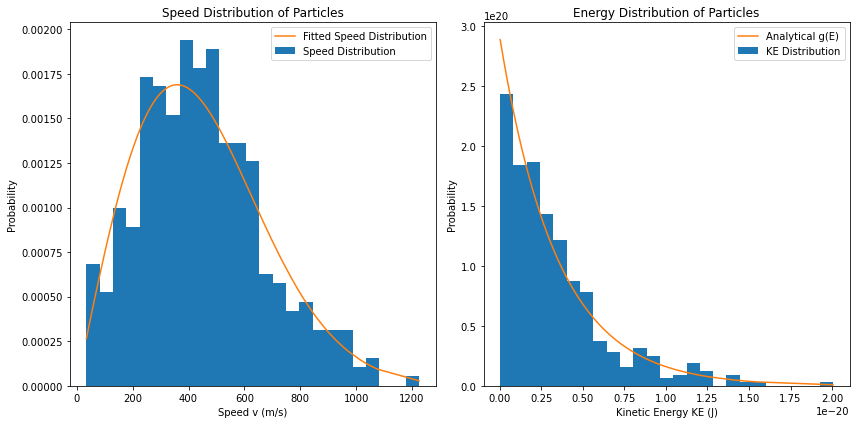

In [71]:
# Plots, fits and temperature output line here
# YOUR CODE HERE

# calculate Speed and Kinetic Energy of every particle
speed = (vx**2 + vy**2)**0.5
KE = 0.5 * particle_mass * speed**2
kB = 1.38e-23  # Boltzmann constant (kg s-2 K-1)


def fit_speed(v, T):
    """ Maxwell Boltzmann distribution of speed to fit """
    return particle_mass * v * np.exp(-particle_mass * v**2 /
                                      (2 * kB * T)) / (kB * T)


def fit_KE(E, T):
    """ Boltzmann distribution of Kinetic Energy """
    return np.exp(-E / (kB * T)) / (kB * T)


# initial guess of the temperature of the system
T_guess = 250

# set figure size
plt.figure(figsize=(12, 6))

# speed distribution
plt.subplot(1, 2, 1)

# plot histogram and get data to fit
counts, bins, patches = plt.hist(speed,
                                 density=True,
                                 bins=25,
                                 label='Speed Distribution')
bin_center = np.array(
    [0.5 * (bins[i] + bins[i + 1]) for i in range(len(bins) - 1)])

# fitted data, popt = fitted parameters
popt, pcov = curve_fit(fit_speed, xdata=bin_center, ydata=counts, p0=T_guess)
# errors of the fitted parameters
perr = np.sqrt(np.diag(pcov))

# print estimated temperature obtained by fitting the speed distribution
print("Estimated Temperature = {e_t} ± {e} Kelvin".format(
    e=np.round(perr[0], 2), e_t=np.round(popt[0], 2)))

new_data = np.unique(speed)
plt.plot(new_data,
         fit_speed(new_data, *popt),
         label='Fitted Speed Distribution')

plt.legend()
plt.title("Speed Distribution of Particles")
plt.xlabel("Speed v (m/s)")
plt.ylabel("Probability")

# KE distribution
plt.subplot(1, 2, 2)

# plot histogram
plt.hist(KE, density=True, bins=25, label='KE Distribution')
# plot analytical g(E) with fitted temperature
new_data = np.unique(KE)
plt.plot(new_data, fit_KE(new_data, popt[0]), label='Analytical g(E)')

plt.legend()
plt.title("Energy Distribution of Particles")
plt.xlabel("Kinetic Energy KE (J)")
plt.ylabel("Probability")

plt.tight_layout()
plt.show()
plt.close()

# Acknowledgements

In the cell below, please describe the role of **anyone other than yourself** who contributed to the work shown in this notebook.

Its ok to get help from us and classmates! Please get in the habit of acknowledging such contributions.

If you want to refer to a classmate, please use only their cocalc email-id and not their name - or you could just say something like: "a classmate gave me the idea to use xxx feature to solve yyy problem."


_Acknowledgements here:_



# Extension Code and Description
All solution code for the main project question should appear in the two main cells above above. Project extensions go in the cell "cell-extension" immediately below and the descriptions of your extension go in the cell below that.

In [62]:
# OPTIONAL project extension here
# These can call functions in your code above if desired
# YOUR CODE HERE



_In this cell, please describe any new language features or project extension you have implemented:_




# Grading cells
The cells below marked as "grade use only" are created as placeholders so that we can provide a manual grade and comments for each category. 

Exceptions are the "2. Style" test, which has an associated autograder test that you can run to check style and the timing cell "cell-optimization0", which you can use to test your code execution time.

In [63]:
# 1. Code execution (grader use only)

In [64]:
# 2. Style: pep8 (see note below regarding use of the Format button to fix many errors)
#
# Tests for pep8 returns warnings or errors. You may need to hit 'Save' after making changes for them to take effect.
nb_name = "project04.ipynb"
cells_to_check = []
stop_at = ['cell-extension']
# check_style2.py uses cells_to_check and nb_name
%run -i check_style2.py

checking cell: cell-project4-1
checking cell: cell-project4-2


Also note that you can use the Format button while in a code cell to automagically fix most pep8 errors (other than way too long print statements)

![](project02-format.png)

In [65]:
# 3. Results (grader use only)

In [66]:
# 4. Readability (grader use only)

In [67]:
# 5. Plot (grader use only)

.....................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................................Time for cell: cell-project4-1 time: 128.25
Estimated Temperature = 249.68 ± 14.09 Kelvin


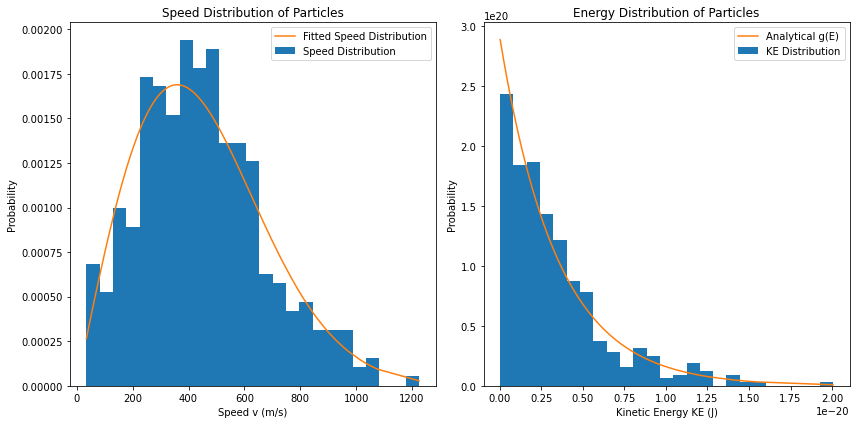

Time for cell: cell-project4-2 time: 0.73
Total time: 128.98


In [68]:
# Check execution time
nb_name = "project04.ipynb"
cells_to_time = []
stop_at = ['cell-extension']
%run -i time_cells2.py

In [69]:
# 5. Code optimization/timing (grader use only)

In [70]:
# B2. New Functionality/Language features (grader use only)